# Apply time series modelling using SARIMA

This notebook try to analyze the time-series data using Auto-regressive integrated moving average (ARIMA)

## Univariate modelling

In [106]:
# import necessary packages
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

from datetime import datetime
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm

import sys
sys.path.append("../../PredictPIServer/ValePredictPI/")

from vale_connect import ValeConnect

In [107]:
# import PI Data on the same timeframe
# create connection
server_root = '142.40.33.208'
server_base = 'pti-pi'

conn = ValeConnect(server_root, server_base)

pi_tag = ['U-LGS1-UGB-X-PK-PK-70-AI','U-LGS1-UGB-Y-PK-PK-340-AI']
time_list = ['2023-10-11 16:07:48','2023-10-11 16:08:58']

for i in range(len(pi_tag)):
    x_tag_wid = conn.get_webid_point(pi_tag[i])

    # for limited data
    # value_resp = conn.get_stream_rec_valuetimestamp_pd(x_tag_wid, time_list)

    # for streaming data
    value_resp = conn.get_stream_rec_valuetime_pd(x_tag_wid)

    if i==0:
        data_pi = value_resp
    else:
        data_pi.insert(i+1, "Values " + str(i), value_resp['Values'])

data_pi

,Timestamps,Values,Values 1
0,2024-05-07T06:38:10.0151824Z,200.8,199.100000
1,2024-05-07T06:38:20.0077514Z,191.7,194.300000
2,2024-05-07T06:38:30.014328Z,186.0,198.700000
3,2024-05-07T06:38:40.0139007Z,190.2,210.000000
4,2024-05-07T06:38:50.0154876Z,193.6,188.700000
...,...,...,...
995,2024-05-07T09:27:00.029663Z,211.6,197.700000
996,2024-05-07T09:27:10.0232391Z,199.7,192.900009
997,2024-05-07T09:27:20.0268096Z,184.1,197.100000
998,2024-05-07T09:27:30.0173797Z,192.6,200.700000


In [98]:
# convert time series data 
for i in range(len(data_pi['Timestamps'])):
    date_str = data_pi['Timestamps'][i][11:19]
    #date_str = str(date_str)
         
    #date_format = '%H:%M:%S'
    #date_data = datetime.strptime(date_str, date_format)
    data_pi['Timestamps'][i] = date_str

/tmp/ipykernel_28156/2496222792.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pi['Timestamps'][i] = date_str


In [108]:
data_pi.index[-1]

999

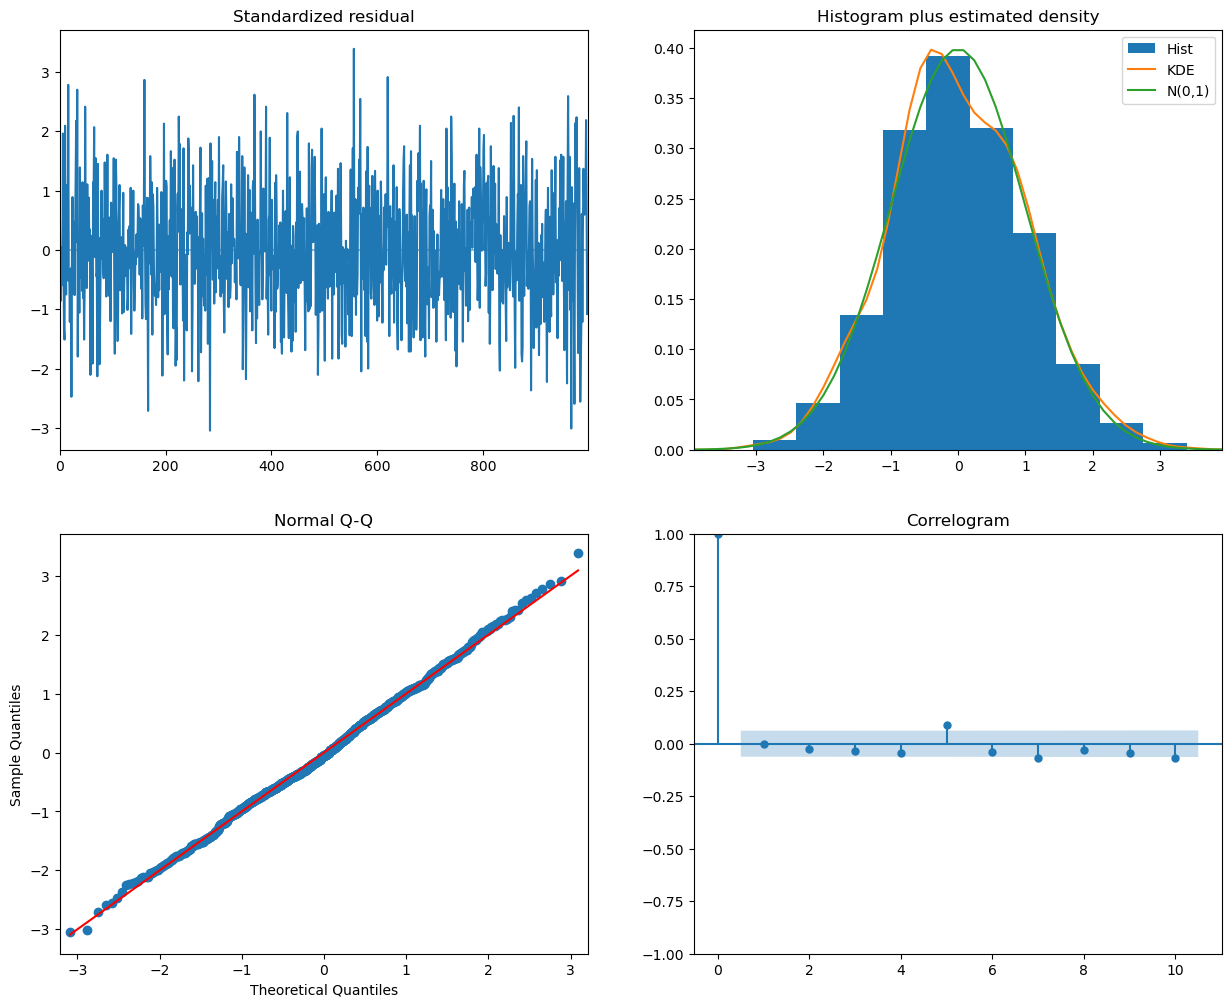

In [117]:
#Standard ARIMA Model
df = data_pi
SARIMA_model = pm.auto_arima(data_pi['Values'], 
                      start_p=1, 
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      # max_p=3, max_q=3, # maximum p and q
                      m=12, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      D=1,
                      seasonal=True, # No Seasonality for standard ARIMA
                      trace=False, #logs 
                      error_action='ignore', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)

ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

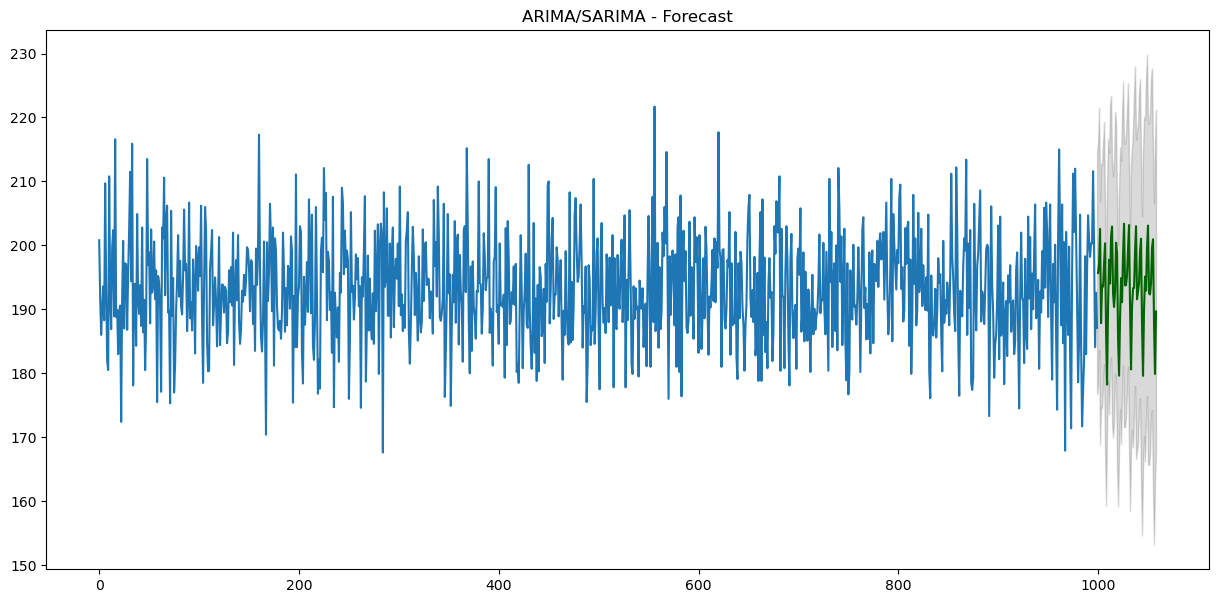

In [118]:
def forecast(ARIMA_model, periods=60):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = range(df.index[-1], df.index[-1] + n_periods, 1)

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df["Values"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("ARIMA/SARIMA - Forecast")
    plt.show()

forecast(SARIMA_model)

## Multivariate modelling

In [55]:
# import necessary packages
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import warnings
import statsmodels.api as sm 
import seaborn as sns 
warnings.filterwarnings("ignore")

from datetime import datetime
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn import metrics
from timeit import default_timer as Timer


In [15]:
# additional function
def tsplot(y, title, lags=None, figsize=(10, 6)):
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    ts_ax.set_title(title, fontsize=12, fontweight='bold')
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    sm.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax)
    sm.graphics.tsa.plot_pacf(y, lags=lags, ax=pacf_ax)
    sns.despine()
    plt.tight_layout()
    plt.show()
    return ts_ax, acf_ax, pacf_ax

In [4]:
# load the data
db_data_hl = pd.read_excel("LGS1_VibrationOrbit_2023_HighLoad.xlsx", sheet_name="Orbit Comparison")
db_data_nl = pd.read_excel("LGS1_VibrationOrbit_2023_NormalLoad.xlsx", sheet_name="Orbit Comparison")
db_data_ll = pd.read_excel("LGS1_VibrationOrbit_2023_LowLoad.xlsx", sheet_name="Orbit Comparison")

In [59]:
# extract the variable
db_data = db_data_hl

ugb_x = db_data['UGB – Disp – Overall – X']
ugb_y = db_data['UGB – Disp – Overall – Y']

ugb = db_data[['UGB – Disp – Overall – X', 'UGB – Disp – Overall – Y']]
ugb

,UGB – Disp – Overall – X,UGB – Disp – Overall – Y
0,-43.28629,-4.445896
1,-42.30980,-2.912147
2,-42.68982,-7.454533
3,-40.86244,-8.992577
4,-48.38764,-1.951850
...,...,...
4091,30.59824,-21.494330
4092,39.80710,-9.170769
4093,41.70255,-10.729640
4094,35.06261,-22.631810


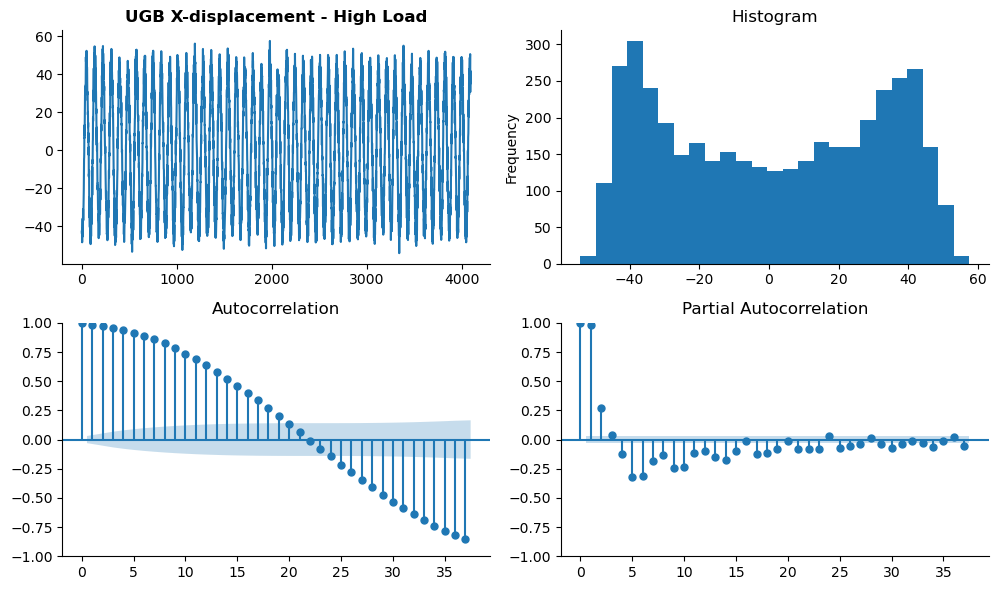

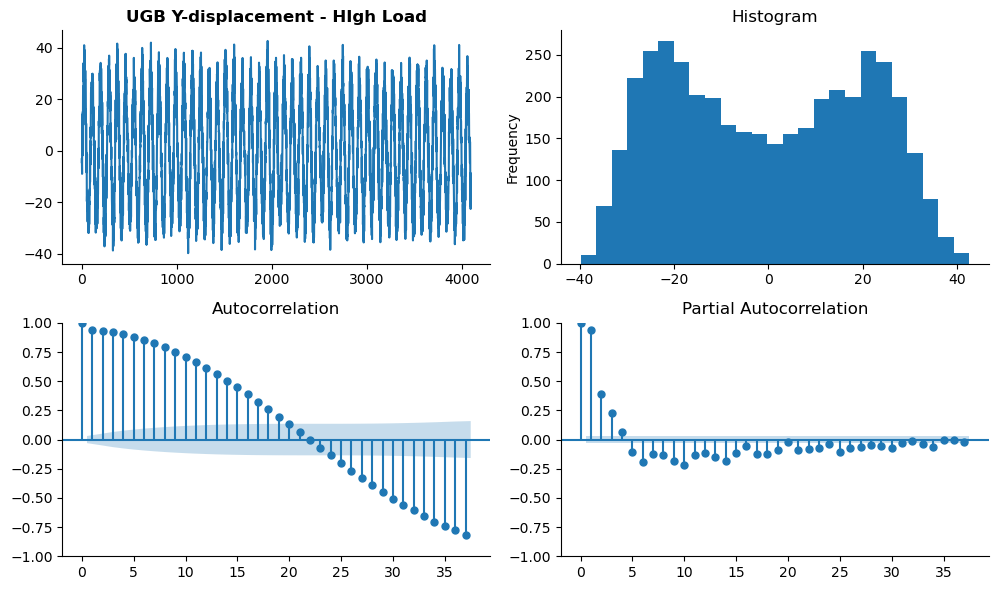

(<Axes: title={'center': 'UGB Y-displacement - HIgh Load'}>,
 <Axes: title={'center': 'Autocorrelation'}>,
 <Axes: title={'center': 'Partial Autocorrelation'}>)

In [25]:
tsplot(ugb_x, 'UGB X-displacement - High Load')
tsplot(ugb_y, 'UGB Y-displacement - HIgh Load')

In [48]:
# create train test data

train, test = train_test_split(ugb, test_size=0.2)
len(test)

820

In [61]:
# create the time series model
model = sm.tsa.VARMAX(train, order=(5, 5), trend='c')
model_result = model.fit(maxiter=1000, disp=False)
model_result.summary()

Dep. Variable:,"['UGB – Disp – Overall – X', 'UGB – Disp – Overall – Y']",No. Observations:,3276
Model:,"VARMA(5,5)",Log Likelihood,-30305.919
,+ intercept,AIC,60701.838
Date:,"Fri, 10 May 2024",BIC,60976.085
Time:,04:39:55,HQIC,60800.043
Sample:,0,,
,- 3276,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.02, 0.00",Jarque-Bera (JB):,"269.20, 226.09"
Prob(Q):,"0.88, 0.98",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"1.01, 1.00",Skew:,"-0.00, 0.01"


In [62]:
# calculate the criteria
for i in range(5):
    i += 1
    model = sm.tsa.VARMAX(train, order=(i,0))
    model_result = model.fit(maxiter=1000, disp=False)
    print('Order = ', i)
    print('AIC: ', model_result.aic)
    print('BIC: ', model_result.bic)
    print('HQIC: ', model_result.hqic)

Order =  1
AIC:  60687.74754672194
BIC:  60742.5969527267
HQIC:  60707.38860315068
Order =  2
AIC:  60693.28484292707
BIC:  60772.511762711714
HQIC:  60721.65525776857
Order =  3
AIC:  60691.68755105683
BIC:  60795.29198462137
HQIC:  60728.78732431111
Order =  4
AIC:  60691.56634128364
BIC:  60819.548288628066
HQIC:  60737.39547295069
Order =  5
AIC:  60697.98927312175
BIC:  60850.34873424607
HQIC:  60752.547763201575


In [63]:
# forecast
forecast = model_result.forecast(steps=820)

#pd.concat([ugb['UGB – Disp – Overall – X'][-820:], forecast], axis=1)
x_rmse = np.sqrt(metrics.mean_squared_error(ugb['UGB – Disp – Overall – X'][-820:], forecast['UGB – Disp – Overall – X'][-820:]))
x_rmse

y_rmse = np.sqrt(metrics.mean_squared_error(ugb['UGB – Disp – Overall – Y'][-820:], forecast['UGB – Disp – Overall – Y'][-820:]))
y_rmse

20.081502231982558

In [ ]:
# plot the result